In [2]:

import os
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [3]:
# === PyTorch: Set device ===
# Load dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv(r"C:\Users\Ayush\Downloads\CICIDS2017_Multiclass_Merged.csv")

# Strip whitespace from column names (IMPORTANT!)
df.columns = df.columns.str.strip()

# Show top rows and label distribution
print(df.head())
print(df['Label'].value_counts())

# Drop columns with all NaNs or unnamed indices
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace inf/-inf with NaN, then fill NaNs with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Encode all class labels (multiclass-aware)
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'].astype(str))

# Drop non-numeric columns EXCEPT 'Label'
non_numerics = df.select_dtypes(include=['object']).columns
df = df.drop(non_numerics.difference(['Label']), axis=1)

# Separate features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Feature dimension:", X_train.shape[1])


   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             49188              4                  2                       0   
1             49188              1                  2                       0   
2             49188              1                  2                       0   
3             49188              1                  2                       0   
4             49486              3                  2                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           12                            0   
1                           12                            0   
2                           12                            0   
3                           12                            0   
4                           12                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6            

In [4]:
# Get the encoded value of the "BENIGN" class
benign_label = label_encoder.transform(["BENIGN"])[0]

# Extract only attack samples (all classes except BENIGN)
X_attack = X_train[y_train != benign_label]

print(f"Attack sample count: {X_attack.shape[0]}")
print(f"Feature dimension: {X_attack.shape[1]}")


Attack sample count: 18422
Feature dimension: 78


In [5]:
# === MobileGAN: A PyTorch Implementation for Generating Synthetic Attack Data ===
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
feature_dim = 78
batch_size = 128
lr = 0.0001
epochs = 100

# ===== Generator =====
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, feature_dim),
        )

    def forward(self, z):
        return self.model(z)

# ===== Discriminator =====
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ===== Load and prepare attack data =====
X_attack_tensor = torch.tensor(X_attack, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_attack_tensor), batch_size=batch_size, shuffle=True)

# ===== Initialize models and training utils =====
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# ===== Training Loop =====
for epoch in range(epochs):
    for real_batch, in train_loader:
        real_batch = real_batch.to(device)
        batch_size_curr = real_batch.size(0)

        # Real and fake label smoothing
        real_labels = torch.ones(batch_size_curr, 1).uniform_(0.9, 1.0).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).uniform_(0.0, 0.1).to(device)

        # === Train Discriminator ===
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)

        d_real = discriminator(real_batch)
        d_fake = discriminator(fake_data.detach())

        loss_real = criterion(d_real, real_labels)
        loss_fake = criterion(d_fake, fake_labels)
        d_loss = loss_real + loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        optimizer_D.step()

        # === Train Generator ===
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)
        g_loss = criterion(discriminator(fake_data), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# ===== Save the trained generator =====
torch.save(generator.state_dict(), "mobilegan_generator_stable.pth")

# ===== Function to generate synthetic samples =====
def generate_synthetic_samples(generator, num_samples=1000):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        synthetic_data = generator(z)
    return synthetic_data.cpu().numpy()

# ===== Generate and Save Synthetic Attack Data =====
synthetic_attacks = generate_synthetic_samples(generator, num_samples=1000)
df_synthetic = pd.DataFrame(synthetic_attacks)
df_synthetic.to_csv("synthetic_attacks.csv", index=False)
print(" Synthetic attack data saved as 'synthetic_attacks.csv'")


Epoch [1/100] | D Loss: 1.1085 | G Loss: 0.8361
Epoch [2/100] | D Loss: 1.0567 | G Loss: 0.8866
Epoch [3/100] | D Loss: 0.9441 | G Loss: 1.0962
Epoch [4/100] | D Loss: 1.0246 | G Loss: 0.9990
Epoch [5/100] | D Loss: 1.1477 | G Loss: 1.0233
Epoch [6/100] | D Loss: 1.0173 | G Loss: 1.0941
Epoch [7/100] | D Loss: 1.0242 | G Loss: 1.1381
Epoch [8/100] | D Loss: 0.9240 | G Loss: 1.2350
Epoch [9/100] | D Loss: 0.9527 | G Loss: 1.2363
Epoch [10/100] | D Loss: 1.0500 | G Loss: 1.2274
Epoch [11/100] | D Loss: 1.0749 | G Loss: 1.1224
Epoch [12/100] | D Loss: 0.8845 | G Loss: 1.3013
Epoch [13/100] | D Loss: 1.0330 | G Loss: 1.1803
Epoch [14/100] | D Loss: 1.0171 | G Loss: 1.1963
Epoch [15/100] | D Loss: 0.9824 | G Loss: 1.2321
Epoch [16/100] | D Loss: 1.0238 | G Loss: 1.1970
Epoch [17/100] | D Loss: 1.2056 | G Loss: 1.0717
Epoch [18/100] | D Loss: 1.0350 | G Loss: 1.1834
Epoch [19/100] | D Loss: 0.9684 | G Loss: 1.2008
Epoch [20/100] | D Loss: 0.9182 | G Loss: 1.3591
Epoch [21/100] | D Loss: 0.98

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             49188              4                  2                       0   
1             49188              1                  2                       0   
2             49188              1                  2                       0   
3             49188              1                  2                       0   
4             49486              3                  2                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           12                            0   
1                           12                            0   
2                           12                            0   
3                           12                            0   
4                           12                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6            

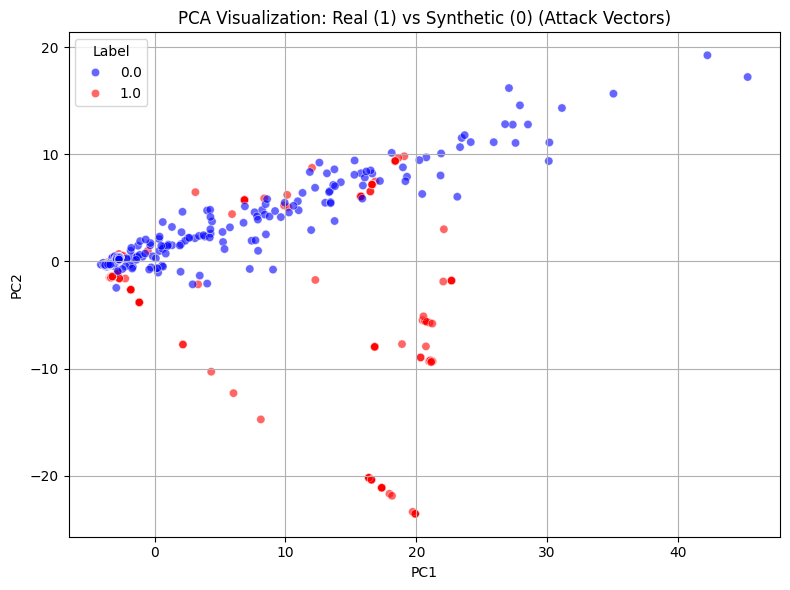

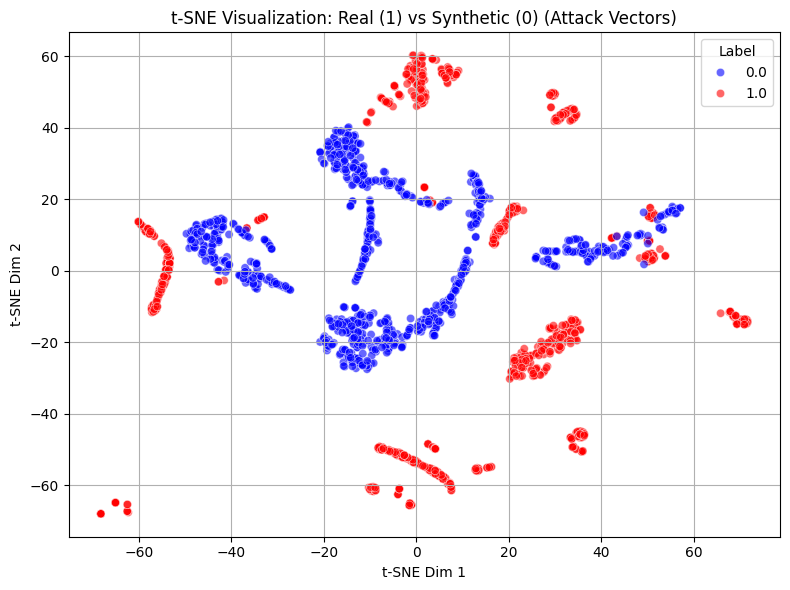

Epoch 1/10, Loss: 8.9737
Epoch 2/10, Loss: 8.5787
Epoch 3/10, Loss: 8.2540
Epoch 4/10, Loss: 8.0278
Epoch 5/10, Loss: 7.8455
Epoch 6/10, Loss: 7.6288
Epoch 7/10, Loss: 7.4961
Epoch 8/10, Loss: 7.3327
Epoch 9/10, Loss: 7.2256
Epoch 10/10, Loss: 7.1850

📊 Discriminator Evaluation Report:
              precision    recall  f1-score   support

         0.0     0.6604    0.8750    0.7527       200
         1.0     0.8148    0.5500    0.6567       200

    accuracy                         0.7125       400
   macro avg     0.7376    0.7125    0.7047       400
weighted avg     0.7376    0.7125    0.7047       400

ROC-AUC Score: 0.7484

Confusion Matrix:
[[175  25]
 [ 90 110]]


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load and preprocess dataset ===
df = pd.read_csv(r"C:\Users\Ayush\Downloads\CICIDS2017_Multiclass_Merged.csv")
df.columns = df.columns.str.strip()

print(df.head())
print(df['Label'].value_counts())

# Drop columns with all NaNs or unnamed indices
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace inf/-inf with NaN, then fill NaNs with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'].astype(str))

# Drop non-numeric columns except Label
non_numerics = df.select_dtypes(include=['object']).columns
df = df.drop(non_numerics.difference(['Label']), axis=1)

# Split features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print("Training samples:", X_train.shape[0])
print("Feature dimension:", X_train.shape[1])

# === Extract attack data (exclude BENIGN) ===
benign_label = label_encoder.transform(["BENIGN"])[0]
X_attack = X_train[y_train != benign_label]

# === MobileGAN Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
feature_dim = X_attack.shape[1]
batch_size = 128
lr = 0.0001
epochs = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, feature_dim),
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Prepare data
X_attack_tensor = torch.tensor(X_attack, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_attack_tensor), batch_size=batch_size, shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Train MobileGAN
for epoch in range(epochs):
    for real_batch, in train_loader:
        real_batch = real_batch.to(device)
        batch_size_curr = real_batch.size(0)

        real_labels = torch.ones(batch_size_curr, 1).uniform_(0.9, 1.0).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).uniform_(0.0, 0.1).to(device)

        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)

        d_real = discriminator(real_batch)
        d_fake = discriminator(fake_data.detach())

        loss_real = criterion(d_real, real_labels)
        loss_fake = criterion(d_fake, fake_labels)
        d_loss = loss_real + loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        optimizer_D.step()

        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)
        g_loss = criterion(discriminator(fake_data), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

torch.save(generator.state_dict(), "mobilegan_generator_stable.pth")

def generate_synthetic_samples(generator, num_samples=1000):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        synthetic_data = generator(z)
    return synthetic_data.cpu().numpy()

synthetic_attacks = generate_synthetic_samples(generator, num_samples=1000)
df_synthetic = pd.DataFrame(synthetic_attacks)
df_synthetic.to_csv("synthetic_attacks.csv", index=False)
print("Synthetic attack data saved as 'synthetic_attacks.csv'")

# === Evaluation: Real vs Synthetic Discriminator ===
real_attacks = X_attack
synthetic_attacks = pd.read_csv("synthetic_attacks.csv").values

min_len = min(len(real_attacks), len(synthetic_attacks))
real_balanced = real_attacks[:min_len]
synthetic_balanced = synthetic_attacks[:min_len]

real_labels = np.ones((min_len, 1))
synthetic_labels = np.zeros((min_len, 1))

X_eval = np.vstack([real_balanced, synthetic_balanced])
y_eval = np.vstack([real_labels, synthetic_labels]).flatten()

# Visualization

def plot_visualizations(X_data, y_data, title_suffix=""):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_data, palette=["blue", "red"], alpha=0.6)
    plt.title(f"PCA Visualization: Real (1) vs Synthetic (0) {title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(X_data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_data, palette=["blue", "red"], alpha=0.6)
    plt.title(f"t-SNE Visualization: Real (1) vs Synthetic (0) {title_suffix}")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(title="Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_visualizations(X_eval, y_eval, "(Attack Vectors)")

X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_eval, y_eval, test_size=0.2, random_state=42, stratify=y_eval
)

X_train_tensor = torch.tensor(X_train_eval, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_eval, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_eval, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_eval, dtype=torch.float32).view(-1, 1)

input_dim = X_train_tensor.shape[1]

eval_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

disc_eval = Discriminator(input_dim=input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(disc_eval.parameters(), lr=0.0001)

for epoch in range(10):
    disc_eval.train()
    epoch_loss = 0
    for xb, yb in eval_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = disc_eval(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {epoch_loss:.4f}")

disc_eval.eval()
with torch.no_grad():
    preds = disc_eval(X_test_tensor.to(device)).cpu().numpy().flatten()
    preds_binary = (preds >= 0.5).astype(int)

print("\n\U0001F4CA Discriminator Evaluation Report:")
print(classification_report(y_test_tensor, preds_binary, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test_tensor, preds):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tensor, preds_binary))


In [7]:
import numpy as np
import pandas as pd

# 1. Get benign samples
benign_label = label_encoder.transform(["BENIGN"])[0]
X_benign = X_train[y_train == benign_label]
y_benign = np.zeros((X_benign.shape[0],))  # Label: 0

# 2. Use real attacks
X_real_attack = X_attack
y_real_attack = np.ones((X_real_attack.shape[0],))  # Label: 1

# 3. Load synthetic attacks
X_synth_attack = pd.read_csv("synthetic_attacks.csv").values
y_synth_attack = np.ones((X_synth_attack.shape[0],))  # Label: 1

# 4. Combine all
X_ids = np.vstack([X_benign, X_real_attack, X_synth_attack])
y_ids = np.hstack([y_benign, y_real_attack, y_synth_attack])

print(f"Total IDS dataset size: {X_ids.shape}")
print(f"Class distribution: Normal = {(y_ids==0).sum()}, Attack = {(y_ids==1).sum()}")


Total IDS dataset size: (839860, 78)
Class distribution: Normal = 820438, Attack = 19422


In [8]:
X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(
    X_ids, y_ids, test_size=0.2, random_state=42, stratify=y_ids
)

# Reshape for 1D CNN: (batch, channels=1, features)
X_train_tensor = torch.tensor(X_train_ids, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_ids, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_ids, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_ids, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

# Define 1D CNN model
class CNN_IDS(nn.Module):
    def __init__(self, input_len=78):
        super(CNN_IDS, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_IDS().to(device)

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/10, Loss: 137.6520
Epoch 2/10, Loss: 45.0478
Epoch 3/10, Loss: 31.0665
Epoch 4/10, Loss: 23.2294
Epoch 5/10, Loss: 20.8520
Epoch 6/10, Loss: 19.5790
Epoch 7/10, Loss: 18.1427
Epoch 8/10, Loss: 17.4055
Epoch 9/10, Loss: 16.1217
Epoch 10/10, Loss: 15.0024


In [10]:
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model(xb).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds)
        all_probs.extend(probs)

# Metrics
print("\n📊 IDS Classifier Evaluation Report:")
print(classification_report(y_test_ids, all_preds, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test_ids, all_probs):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ids, all_preds))



📊 IDS Classifier Evaluation Report:
              precision    recall  f1-score   support

         0.0     0.9999    0.9994    0.9997    164088
         1.0     0.9765    0.9951    0.9857      3884

    accuracy                         0.9993    167972
   macro avg     0.9882    0.9973    0.9927    167972
weighted avg     0.9993    0.9993    0.9993    167972

ROC-AUC Score: 0.9999
Confusion Matrix:
[[163995     93]
 [    19   3865]]


In [11]:
# Export TorchScript model
example_input = torch.rand(1, 1, 78).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("ids_cnn_edgegensec.pt")
print("✅ TorchScript model saved as 'ids_cnn_edgegensec.pt'")


✅ TorchScript model saved as 'ids_cnn_edgegensec.pt'


In [12]:
import os
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir())


Current working directory: c:\Users\Ayush\Downloads
Files in directory: ['!!tFzIX_qhlogs.txt', '!!VJc2Y_qhlogs.txt', '!qhlogs.doc', '(Audio) 2024-11-25 20-15-07.m4a', '(Audio) Lethal Company 2024.10.02 - 16.27.54.04.DVR.m4a', '.idea', '.ipynb_checkpoints', '.vscode', '0.0001 second of somethin.m4a', '03EnhancingHuman-RobotCollaborationinIndustry_Naveen_vemuri_Power.pdf', '1-s2.0-S0370269323007165-main.pdf', '1. Even Semester_Theory Examination Schedule_17.04.2025.pdf', '10.1016@j.smhl.2019.100093.pdf', '10.1561-116.00000064.bib', '1710.10570v2.pdf', '1FD0hwA_qhlogs.csv', '1QcwXlj_qhlogs.csv', '1RVU23CSE082- LAB experiment -01.pdf', '1RVU23CSE082- Lab experiment -02.pdf', '1RVU23CSE082_Lab10.docx', '1RVU23CSE082_Lab9.docx', '1RVU23CSE094 (1).docx', '1RVU23CSE094 (2).docx', '1RVU23CSE094 (3).docx', '1RVU23CSE094.docx', '1RVU23CSE094.pptx', '1RVU23CSE094.sql', '1RVU23CSE094_Activity2.py', '1RVU23CSE094_Activity6_Level_1.py', '1RVU23CSE094_Activity8.py', '1RVU23CSE094_Activity9.py', '1RVU2

In [16]:
import torch.quantization

# Load model weights if not already
model = CNN_IDS()
model = torch.jit.load("ids_cnn_edgegensec.pt")
model.eval()

# Apply dynamic quantization (weights → int8)
quantized_model = torch.quantization.quantize_dynamic(
    model,  # model to quantize
    {nn.Linear},  # only quantize linear layers (safe for 1D CNNs)
    dtype=torch.qint8
)

# Save quantized model
torch.save(quantized_model.state_dict(), "cnn_ids_quantized.pth")

# (Optional) Use this model for inference
# quantized_model(input_tensor)
